**关于该Notebook**

任务: 以沪深300数据集为例，使用scutquant包完成从原始数据到因子，再到拟合模型和回测的全过程。具体包括:  

(1)、使用**scutquant**(scutquant包下面的一个模块)和**alpha**构造目标值和因子，并自动完成特征工程和数据清洗(包括拆分数据集、填充和去除缺失值、标准化、截断异常值、重采样和降采样、特征筛选和正则化)  

(2)、使用**scutquant**一键建模(以lightgbm和岭回归为例), 并将模型加权组合成混合模型  

(3)、使用**scutquant**的ic_ana计算IC、Rank IC和pearson相关系数等指标，并评价模型拟合情况(指标越高越好), IC的计算方式为  
 $$IC(t) = PearsonCorr(predict_{t}, y_{t})$$  
 其中, $PearsonCorr(x, y) = \frac{cov(x,y)}{\sqrt{\sigma_x * \sigma_y}}$, $predict_t$ 为t时刻所有资产的预测值序列(即截面上的预测值), 同理$y_t$ 为截面上的真实值
 
(4)、判断多因子在该模型下是否有效的t检验为 $t = ICIR * \sqrt{\Delta T}$, 其中$ICIR=\frac{\bar{IC}}{\sigma{IC}}$, $\Delta T$为时间间隔(例如测试集的天数). 该方法仅在IC分布为正态分布时成立(ic_ana会输出IC序列的分布图)  

(5)、使用**report**模块查看分组情况(按照每个time_tick的预测情况，对所有资产从高到低分成n组，并计算它们的累计平均收益率)。如果Group1到Group5呈现了明显的单调性(几条曲线交错很少, 且1~5由高到低呈现)则说明因子和模型的选股能力较强，因子较有效.  

5.1、其中, long-short为做多Group1(预测值最高)做空Group5(预测值最低)的累计收益，long-average为做多Group1并无差别做空资产池的累计收益(因为中国股市严格限制做空，因此long-short的收益难以实现，但是可以通过做空股指期货的做法实现套利, 而average对应的就是股指期货)，并给出预测的准确率($predict_{i,t}>=0$且$y_{i,t}>=0$或$predict_{i,t}<0$且$y_{i,t}<0$则为正确，否则为错误)  

(6)、使用**executor**模块执行回测, 需要在字典中写好策略和其它必要的参数, 并使用**report**模块报告回测结果  

In [1]:
# 导入需要用到的库
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

In [3]:
# 查看数据集信息
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1199445 entries, (Timestamp('2006-01-04 00:00:00'), '000001.SZ') to (Timestamp('2022-12-30 00:00:00'), '688981.SH')
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        1199445 non-null  float64
 1   high        1199445 non-null  float64
 2   low         1199445 non-null  float64
 3   close       1199445 non-null  float64
 4   pre_close   1199445 non-null  float64
 5   change      1199445 non-null  float64
 6   pct_chg     1199445 non-null  float64
 7   vol         1199445 non-null  float64
 8   amount      1199445 non-null  float64
 9   mean_price  1199445 non-null  float64
dtypes: float64(10)
memory usage: 96.3+ MB


**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 因子的构建方法有很多种, 关于因子可以查看alpha模块的注释以及量协的各种资料. 但我们在这里仅使用原始数据的0~59阶滞后项构建因子，让模型从它们张成的360维空间中寻找有用的信息预测目标值(可以跟tutorial(dnn)作比较)

In [4]:
# 构造目标值, 并按照-10% 和10%截断(因为有涨跌停限制)
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna()
df["label"].clip(-0.1, 0.1, inplace=True) 
df["label"].describe()

count    1.197673e+06
mean     5.829445e-04
std      2.843395e-02
min     -1.000000e-01
25%     -1.330000e-02
50%      0.000000e+00
75%      1.370000e-02
max      1.000000e-01
Name: label, dtype: float64

In [5]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
    "groupby": "instrument"
}
X = alpha.alpha360(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

open1     open2     open3     open4     open5  \
datetime   instrument                                                     
2006-04-07 000001.SZ   1.024730  1.015456  0.990726  0.976816  0.973725   
           000002.SZ   1.023426  0.995608  1.010249  0.959004  0.951684   
           000059.SZ   0.955711  0.960373  0.958042  0.930070  0.923077   
           000061.SZ   0.876122  0.829443  0.829443  0.800718  0.804309   
           000063.SZ   1.013342  0.987929  1.012706  0.972363  0.959339   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.963159  0.955070  0.951026  0.914111  0.904552   
           688396.SH   0.999434  0.990377  1.000000  1.015094  1.023019   
           688561.SH   1.024219  1.031379  0.938157  0.938309  0.941356   
           688599.SH   0.942443  0.863839  0.873565  0.858099  0.874043   
           688981.SH   1.011980  1.000000  1.000000  1.015892  1.020293   

                          open6     open7     open8     open9    open10  ...  \
datetime   instrument                                                    ...   
2006-04-07 000001.SZ   1.003091  0.989181  0.981453  0.975270  0.989181  ...   
           000002.SZ   0.966325  0.959004  0.913616  0.868228  0.878477  ...   
           000059.SZ   0.932401  0.951049  0.953380  0.934732  0.946387  ...   
           000061.SZ   0.825853  0.798923  0.771993  0.777379  0.789946  ...   
           000063.SZ   0.945044  0.930432  0.932338  0.927573  0.921220  ...   
...                         ...       ...       ...       ...       ...  ...   
2022-12-28 688363.SH   0.919921  0.941246  0.932642  0.956688  0.919185  ...   
           688396.SH   1.024717  1.074528  1.065660  1.068679  1.107547  ...   
           688561.SH   0.974867  0.982635  1.002285  0.990251  0.967251  ...   
           688599.SH   0.882175  0.872449  0.883291  0.876276  0.893973  ...   
           688981.SH   1.016626  1.046455  1.039120  1.038142  1.074817  ...   

                       amount52  amount53  amount54  amount55  amount56  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.077210  0.064337  0.054171  0.078648  0.173116   
           000002.SZ   0.070373  0.070449  0.048691  0.052976  0.060270   
           000059.SZ   0.027743  0.033839  0.035324  0.057521  0.094596   
           000061.SZ   0.016100  0.009716  0.011192  0.020518  0.017056   
           000063.SZ   0.028738  0.026976  0.039886  0.038801  0.028084   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.042483  0.057178  0.039490  0.037668  0.033272   
           688396.SH   0.155135  0.171983  0.122359  0.175270  0.108399   
           688561.SH   0.156938  0.092316  0.139302  0.078257  0.056223   
           688599.SH   0.155566  0.213565  0.126343  0.091361  0.053551   
           688981.SH   0.180326  0.226451  0.164799  0.154050  0.157421   

                       amount57  amount58  amount59  amount60     label  
datetime   instrument                                                    
2006-04-07 000001.SZ   0.090984  0.198515  0.125080  0.125308  0.026700  
           000002.SZ   0.050402  0.059178  0.054714  0.049890  0.025300  
           000059.SZ   0.063895  0.142202  0.058425  0.019139 -0.020700  
           000061.SZ   0.030299  0.029542  0.020071  0.046194 -0.001800  
           000063.SZ   0.062820  0.054851  0.046420  0.059121 -0.007900  
...                         ...       ...       ...       ...       ...  
2022-12-28 688363.SH   0.051896  0.032411  0.042411  0.042831 -0.001550  
           688396.SH   0.249247  0.183622  0.158856  0.164713 -0.004161  
           688561.SH   0.083808  0.063439  0.081799  0.104741  0.004736  
           688599.SH   0.071348  0.070434  0.057827  0.057153  0.008861  
           688981.SH   0.178280  0.091555  0.100307  0.087161  0.006114  

[1144849 rows x 361 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 863009 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2018-12-28 00:00:00'), '603993.SH')
Columns: 361 entries, open1 to label
dtypes: float64(361)
memory usage: 2.3+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 



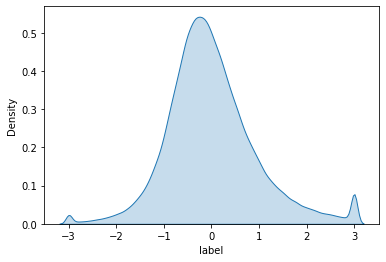

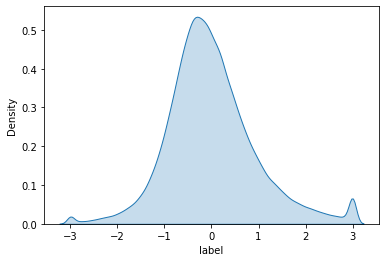

norm data done 

all works done 



In [6]:
# 按时间划分出训练集和测试集
X_train = X[X.index.get_level_values(0) <= "2018-12-31"]
X_test = X[X.index.get_level_values(0) >= "2019-01-01"]

# 从训练集中按7：3的比例随机拆分出验证集, 并在截面上进行标准化
result = q.auto_process(X_train, "label", groupby="instrument", datetime="datetime", 
                        split_params={"method": "split", "params": {"test": 0.3}}, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_test"], result["y_test"]

# 处理测试集
y_test = X_test.pop("label")
x_mean, x_std = X_test.groupby("datetime").mean(), X_test.groupby("datetime").std()
X_test = q.zscorenorm(X_test, x_mean, x_std)

y_mean = y_test.groupby("instrument").shift(2).groupby("datetime").mean()
y_std = y_test.groupby("instrument").shift(2).groupby("datetime").std()
y_mean.fillna(0.0002, inplace=True)  # 假设年化5%, 则每天应为0.0002
y_std.fillna(0.0189, inplace=True)  # 假设年化波动率为30%, 即0.3, 则每天的波动率应为0.0189

X_test = X_test.groupby("instrument").fillna(method="ffill").dropna()
y_test = y_test[y_test.index.isin(X_test.index)]

In [7]:
# 查看数据处理的结果
X_train.describe()

,open1,open2,open3,open4,open5,open6,open7,open8,open9,open10,...,amount51,amount52,amount53,amount54,amount55,amount56,amount57,amount58,amount59,amount60
count,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,...,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000,604106.000000
mean,-0.001886,-0.006017,-0.008671,-0.010522,-0.012149,-0.013371,-0.014311,-0.015032,-0.015638,-0.016248,...,-0.028737,-0.028708,-0.028869,-0.028874,-0.028619,-0.029082,-0.029017,-0.029140,-0.029197,-0.029305
std,0.922246,0.903282,0.890462,0.883067,0.877944,0.873692,0.871871,0.871285,0.870522,0.869565,...,0.846504,0.847150,0.845627,0.845885,0.847291,0.843933,0.844785,0.844120,0.843787,0.842986
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,...,-2.134600,-2.042537,-1.936066,-1.953450,-1.960305,-2.013165,-2.255692,-2.027422,-1.892921,-1.852144
25%,-0.477078,-0.466828,-0.463300,-0.460420,-0.461849,-0.461600,-0.463968,-0.467283,-0.469881,-0.471297,...,-0.588927,-0.588118,-0.587950,-0.588004,-0.588812,-0.587091,-0.587955,-0.586800,-0.584746,-0.585379
50%,0.044340,0.029382,0.022633,0.015661,0.009684,0.005715,0.001505,-0.002910,-0.005429,-0.009716,...,-0.228124,-0.229414,-0.227521,-0.229165,-0.228626,-0.228185,-0.228473,-0.229956,-0.230185,-0.230280
75%,0.539813,0.508523,0.489593,0.478851,0.469578,0.463673,0.459752,0.456898,0.453732,0.451162,...,0.278429,0.276140,0.276225,0.273711,0.274989,0.272461,0.272595,0.271687,0.269739,0.271020
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [8]:
# 拟合模型
model = q.auto_lgbm(X_train, y_train, X_valid, y_valid)

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

Training until validation scores don't improve for 30 rounds
[20]	train's l2: 0.884889	valid's l2: 0.899534
[40]	train's l2: 0.883015	valid's l2: 0.898924
[60]	train's l2: 0.881551	valid's l2: 0.898641
[80]	train's l2: 0.880351	valid's l2: 0.898472
[100]	train's l2: 0.879277	valid's l2: 0.89837
[120]	train's l2: 0.87826	valid's l2: 0.898292
[140]	train's l2: 0.877252	valid's l2: 0.898196
[160]	train's l2: 0.876284	valid's l2: 0.898148
[180]	train's l2: 0.875257	valid's l2: 0.898085
[200]	train's l2: 0.874241	valid's l2: 0.89804
[220]	train's l2: 0.873266	valid's l2: 0.898003
[240]	train's l2: 0.872261	valid's l2: 0.897945
[260]	train's l2: 0.871211	valid's l2: 0.897934
[280]	train's l2: 0.870173	valid's l2: 0.897944
[300]	train's l2: 0.869099	valid's l2: 0.897937
Early stopping, best iteration is:
[286]	train's l2: 0.869851	valid's l2: 0.897919


,predict
count,281840.000000
mean,-0.000215
std,0.001410
min,-0.012551
25%,-0.000921
50%,-0.000121
75%,0.000601
max,0.009223


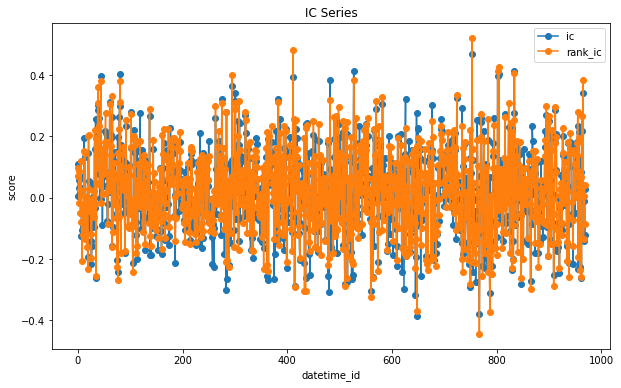

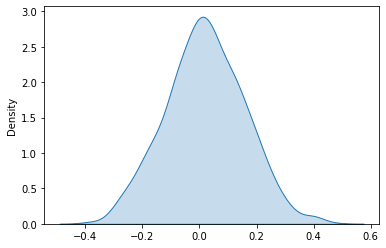

ic= 0.019913770084132174 icir= 0.1438431923657603 rank_ic= 0.025597274409160434 rank_icir= 0.18504065756820223


0.017646867526818353

In [9]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred.values, y_test)
r[0]

In [10]:
# 以下为回测部分
# 将预测值处理成回测需要的格式(需要知道预测值"predict", 交易价格price和交易量volume)
df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')

Accuracy of Prediction: 0.5283347430220409


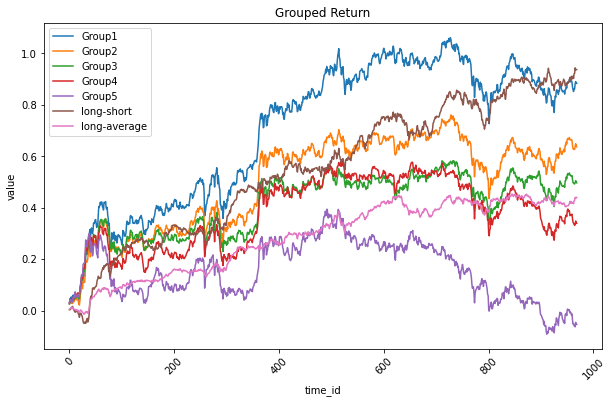

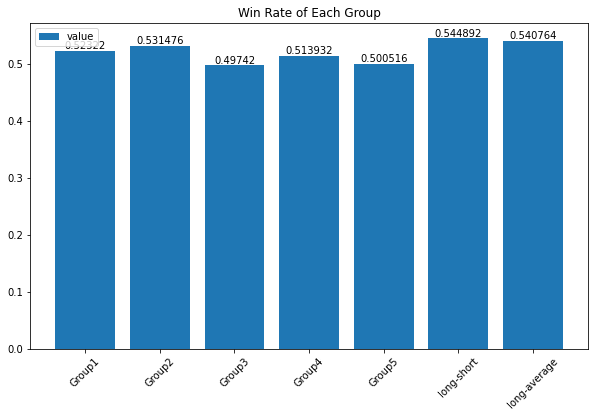

In [11]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)

In [12]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.5  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

E(r): 0.33734152458816485
std: 0.13116763772162307
E(r_benchmark): 0.4145573363202267
std_benchmark: 0.1728743456410088 

Cumulative Rate of Return: 0.29333242774474133
Cumulative Rate of Return(benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: -0.04625313529080732 

Max Drawdown: -0.4146200817930237
Max Drawdown(benchmark): -0.5462600364770351 

Sharpe Ratio: 2.571208406780246
Sortino Ratio: -0.5690319768230517
Information Ratio: -0.5886803564758623 

Beta: 0.7214028260369828
Profitable Days(%): 0.14241486068111456


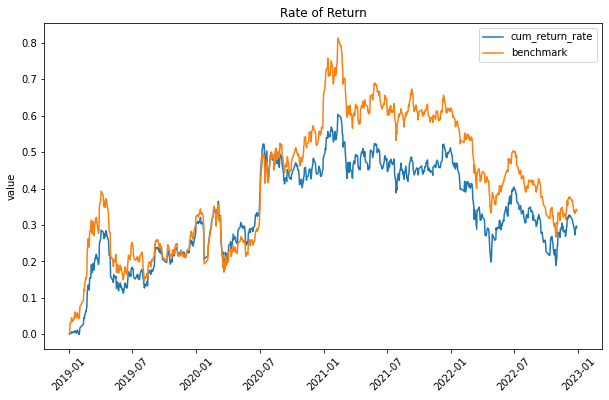

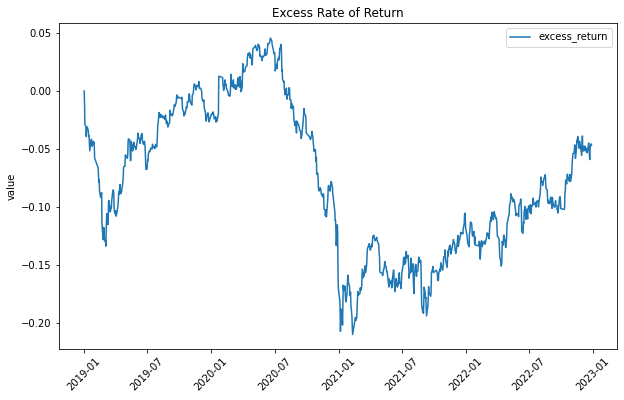

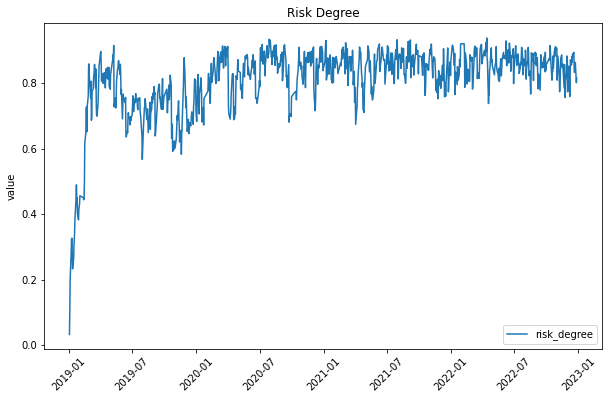

In [13]:
# 报告回测结果
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [14]:
# user_account.buy_hist # 查看历史上所有买单